In [1]:
import pandas as pd
import numpy as np
import simfin as sf
import seaborn as sns
import os
from dotenv import load_dotenv
import klib
import shap
import matplotlib.pyplot as plt
import yfinance as yf
import yahoo_fin.stock_info as si
from yahoo_fin import news
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
from utils import plot_correlation
from simfin.names import *
import pathlib
from category_encoders import OrdinalEncoder
import pickle

In [2]:
# RESOURCES

# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
# https://github.com/skorch-dev/skorch

In [3]:
# SETTINGS
# Set Pandas Options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# Set your API-key for downloading data.
# If the API-key is 'free' then you will get the free data,
load_dotenv()
SIMFIN_API_KEY = os.getenv('SIMFIN_API_KEY')
sf.set_api_key(SIMFIN_API_KEY)

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('simfin_data/')

In [4]:
# Load the annual Income Statements for all companies in USA.
# The data is automatically downloaded if you don't have it already.
# Quarterly Data is Needed for the Growth Signals Below
REFRESH_DAYS = 1

# Common
income_df = sf.load_income(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
income_quarterly_df = sf.load_income(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

balance_df = sf.load_balance(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
balance_quarterly_df = sf.load_balance(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

cashflow_df = sf.load_cashflow(variant='ttm', market='us', refresh_days=REFRESH_DAYS)
cashflow_quarterlay_df = sf.load_cashflow(variant='quarterly', market='us', refresh_days=REFRESH_DAYS)

derived_df = sf.load_derived(variant='ttm', market='us', refresh_days=REFRESH_DAYS)

cache_args = {'cache_name': 'financial_signals',
              'cache_refresh' : 1}

fin_signal_df = sf.fin_signals(df_income_ttm=income_df,
                                df_balance_ttm=balance_df,
                                df_cashflow_ttm=cashflow_df,
                                **cache_args)

cache_args = {'cache_name': 'growth_signals',
              'cache_refresh' : 1}

growth_signal_df = sf.growth_signals(df_income_ttm=income_df,
                  df_income_qrt=income_quarterly_df,
                  df_balance_ttm=balance_df,
                  df_balance_qrt=balance_quarterly_df,
                  df_cashflow_ttm=cashflow_df,
                  df_cashflow_qrt=cashflow_quarterlay_df,
                  **cache_args)


# Shared
shareprices_df = sf.load_shareprices(variant='daily', market='us', refresh_days=REFRESH_DAYS)
company_df = sf.load_companies(market='us', refresh_days=REFRESH_DAYS)
industry_df = sf.load_industries(refresh_days=REFRESH_DAYS)

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-derived-ttm" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-financial_signals.pickle' on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-growth_signals.pickle' on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (0 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (0 days old).
- Loading from disk ... Done!


In [5]:
income_df = income_df.sort_index(level=['Ticker', 'Report Date'], ascending=[1, 1])
# income_df.groupby('Ticker').last()

balance_df = balance_df.sort_index(level=['Ticker', 'Report Date'], ascending=[1, 1])
balance_df.groupby('Ticker').last()

cashflow_df = cashflow_df.sort_index(level=['Ticker', 'Report Date'], ascending=[1, 1])
cashflow_df.groupby('Ticker').last()

,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Net Income/Starting Line,Depreciation & Amortization,Non-Cash Items,Change in Working Capital,Change in Accounts Receivable,Change in Inventories,Change in Accounts Payable,Change in Other,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,
A,45846,USD,2021,Q1,2021-03-02,2021-03-02,"308,000,000.00","311,000,000.00","810,000,000.00","305,000,000.00","274,000,000.00","-171,000,000.00","-98,000,000.00","-71,000,000.00","60,000,000.00","-62,000,000.00",1218000000,"-125,000,000.00",0.00,0.00,"-154,000,000.00","-225,000,000.00","33,000,000.00","-700,000,000.00","-972,000,000.00",104000000
AA,367153,USD,2020,Q4,2021-02-25,2021-02-25,"186,000,000.00","186,000,000.00","-14,000,000.00","653,000,000.00","-221,000,000.00","-24,000,000.00",nan,nan,nan,nan,394000000,"-353,000,000.00","-12,000,000.00","198,000,000.00","-167,000,000.00",nan,"738,000,000.00","1,000,000.00","514,000,000.00",727000000
AAC,939324,USD,2017,Q1,2017-05-04,2018-05-09,"22,985,326.00","22,983,467.00","-27,745,000.00","19,240,000.00","48,553,000.00","-39,828,000.00",nan,nan,nan,nan,220000,"-40,974,000.00",nan,"-18,825,000.00","-59,574,000.00",nan,"-7,717,000.00",nan,"51,997,000.00",-7357000
AAL,68568,USD,2020,Q4,2021-02-17,2021-02-17,"483,888,000.00","483,888,000.00",nan,nan,nan,nan,nan,nan,nan,nan,-6543000000,"-852,000,000.00",nan,0.00,"-4,342,000,000.00","-43,000,000.00","14,750,000,000.00","-173,000,000.00","10,994,000,000.00",109000000
AAMC,847094,USD,2020,Q4,2021-03-03,2021-03-03,"1,631,326.00","1,631,326.00","-14,720,000.00","354,000.00","-4,279,000.00","-547,000.00",nan,nan,nan,nan,18606000,"-86,000.00",0.00,0.00,"3,557,000.00",nan,0.00,"23,000.00","-297,000.00",21842000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTS,378251,USD,2020,Q4,2021-02-16,2021-02-16,"475,502,000.00","478,569,000.00","1,636,000,000.00","441,000,000.00","134,000,000.00","-85,000,000.00",nan,nan,nan,nan,2126000000,"-432,000,000.00",0.00,"-113,000,000.00","-572,000,000.00","-380,000,000.00","744,000,000.00","-250,000,000.00","123,000,000.00",1670000000
ZUMZ,45730,USD,2020,Q4,2021-03-15,2021-03-15,"24,942,000.00","25,398,000.00","76,227,000.00","24,059,000.00","68,485,000.00","-30,359,000.00",nan,nan,nan,nan,138412000,"-9,057,000.00","-101,484,000.00",0.00,"-110,541,000.00",nan,0.00,"-9,540,000.00","-9,694,000.00",21699000
ZUO,994625,USD,2020,Q3,2020-12-08,2020-12-08,"115,918,500.00","115,918,500.00","-78,135,000.00","14,639,000.00","91,321,000.00","-15,665,000.00",nan,nan,nan,nan,12160000,"-20,620,000.00",nan,0.00,"11,705,000.00",nan,"-4,440,000.00","20,084,000.00","15,595,000.00",39426000


In [6]:
# Common
# Remove Columns that exist in other Fundamental DataFrames
balance_columns = balance_df.columns[~balance_df.columns.isin(set().union(income_df.columns))]
cashflow_columns = cashflow_df.columns[~cashflow_df.columns.isin(set().union(income_df.columns))]
derived_df_columns = derived_df.columns[~derived_df.columns.isin(set().union(income_df.columns, 
                                                                             growth_signal_df.columns, 
                                                                             fin_signal_df.columns))]

# Merge the fundamental data into a single dataframe
fundamental_df = income_df.join(balance_df[balance_columns]
                               ).join(cashflow_df[cashflow_columns]
                                     ).join(fin_signal_df
                                           ).join(growth_signal_df
                                                 ).join(derived_df[derived_df_columns])


In [7]:
# klib.missingval_plot(fundamental_df);

In [8]:
# Drop Columns with more then 1-thresh nan values
thresh=0.7
fundamental_df = fundamental_df.dropna(thresh=int(thresh*len(fundamental_df)), axis=1)

2021-03-23 00:15:55.477 INFO    numexpr.utils: NumExpr defaulting to 4 threads.


In [9]:
# Drop Duplicate Index
fundamental_df = fundamental_df[~fundamental_df.index.duplicated(keep='first')]

In [10]:
# Replace Report Date with the Publish Date because the Publish Date is when the Fundamentals are known to the Public 
fundamental_df['Published Date'] = fundamental_df['Publish Date'] 
fundamental_df = fundamental_df.reset_index().set_index(['Ticker','Publish Date'])

In [11]:
# Merge Fundamental with Stock Prices
# Downsample Share Prices to Rolling 30 Day End of Month
method = lambda x: x.last()

shareprices_df = shareprices_df[['Close']].groupby('Ticker').rolling(30, min_periods=1).mean().reset_index(0, drop=True)
shareprices_df = sf.resample(df=shareprices_df, rule='M', method=method)

df = sf.reindex(df_src=fundamental_df, df_target=shareprices_df, group_index=TICKER, method='ffill'
               ).dropna(how='all').join(shareprices_df)


In [12]:
# Common
# Clean Up
df = df.drop(['SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Restated Date', 'Fiscal Period', 'Published Date'], axis=1)
df = df[df['Close'] <= df.loc['AMZN']['Close'].max()] # Remove Share Prices Over Amazon Share Price
df = df.dropna(subset=['Shares (Basic)', 'Shares (Diluted)', 'Revenue', 'Earnings Growth'])
df = df.replace([np.inf, -np.inf], 0)
df = df.fillna(0)


In [13]:
# common
# Calculate Fundamental Data as per share
non_per_share_cols = ['Currency', 'Fiscal Year', 'Fiscal Period', 'Published Date',
                      'Restated Date', 'Shares (Basic)', 'Shares (Diluted)', 'Close',
                      ] + fin_signal_df.columns.tolist() + growth_signal_df.columns.tolist() + derived_df_columns.difference([ 'EBITDA', 'Total Debt', 'Free Cash Flow']).tolist() 

per_share_cols = df.columns[~df.columns.isin(non_per_share_cols)]

df[per_share_cols] =  df[per_share_cols].div(df['Shares (Diluted)'], axis=0)


In [14]:
df.head()

Shares (Basic)  Shares (Diluted)  Revenue  Cost of Revenue  \
Ticker Date                                                                     
A      2011-09-30  346,500,000.00    355,750,000.00    18.17            -8.49   
       2011-10-31  346,500,000.00    355,750,000.00    18.17            -8.49   
       2011-11-30  346,500,000.00    355,750,000.00    18.17            -8.49   
       2011-12-31  347,000,000.00    355,000,000.00    18.63            -8.69   
       2012-01-31  347,000,000.00    355,000,000.00    18.63            -8.69   

                   Gross Profit  Operating Expenses  \
Ticker Date                                           
A      2011-09-30          9.68               -6.97   
       2011-10-31          9.68               -6.97   
       2011-11-30          9.68               -6.97   
       2011-12-31          9.94               -6.92   
       2012-01-31          9.94               -6.92   

                   Selling, General & Administrative  Operating Income (Loss)  \
Ticker Date                                                                     
A      2011-09-30                              -5.16                     2.70   
       2011-10-31                              -5.16                     2.70   
       2011-11-30                              -5.16                     2.70   
       2011-12-31                              -5.10                     3.02   
       2012-01-31                              -5.10                     3.02   

                   Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Date                                                             
A      2011-09-30                         0.04                  -0.19   
       2011-10-31                         0.04                  -0.19   
       2011-11-30                         0.04                  -0.19   
       2011-12-31                        -0.11                  -0.20   
       2012-01-31                        -0.11                  -0.20   

                   Pretax Income (Loss), Adj.  Pretax Income (Loss)  \
Ticker Date                                                           
A      2011-09-30                        2.75                  2.76   
       2011-10-31                        2.75                  2.76   
       2011-11-30                        2.75                  2.76   
       2011-12-31                        2.91                  2.91   
       2012-01-31                        2.91                  2.91   

                   Income Tax (Expense) Benefit, Net  \
Ticker Date                                            
A      2011-09-30                               0.09   
       2011-10-31                               0.09   
       2011-11-30                               0.09   
       2011-12-31                              -0.06   
       2012-01-31                              -0.06   

                   Income (Loss) from Continuing Operations  Net Income  \
Ticker Date                                                               
A      2011-09-30                                      2.85        2.85   
       2011-10-31                                      2.85        2.85   
       2011-11-30                                      2.85        2.85   
       2011-12-31                                      2.85        2.85   
       2012-01-31                                      2.85        2.85   

                   Net Income (Common)  \
Ticker Date                              
A      2011-09-30                 2.85   
       2011-10-31                 2.85   
       2011-11-30                 2.85   
       2011-12-31                 2.85   
       2012-01-31                 2.85   

                   Cash, Cash Equivalents & Short Term Investments  \
Ticker Date                                                          
A      2011-09-30                                             8.72   
       2011-10-31                                             8

In [15]:
df = df.join(company_df).merge(industry_df, left_on='IndustryId', right_index=True).drop(columns=['IndustryId', 'Company Name', 'SimFinId'])

In [16]:
categorical_features = [col for col in df.columns if df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(df)

df=encoder.transform(df)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [17]:
# klib.dist_plot(common_df.Close);
# klib.dist_plot(banks_df.Close);
# klib.dist_plot(insurance_df.Close);

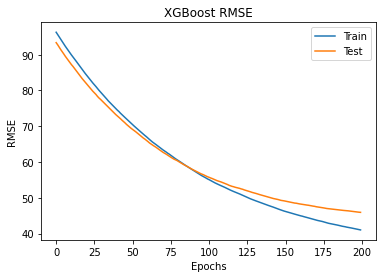

            R2 Score  RMSE
Train/Test                
Train           0.71 41.01
Test            0.62 45.93


Feature Importance


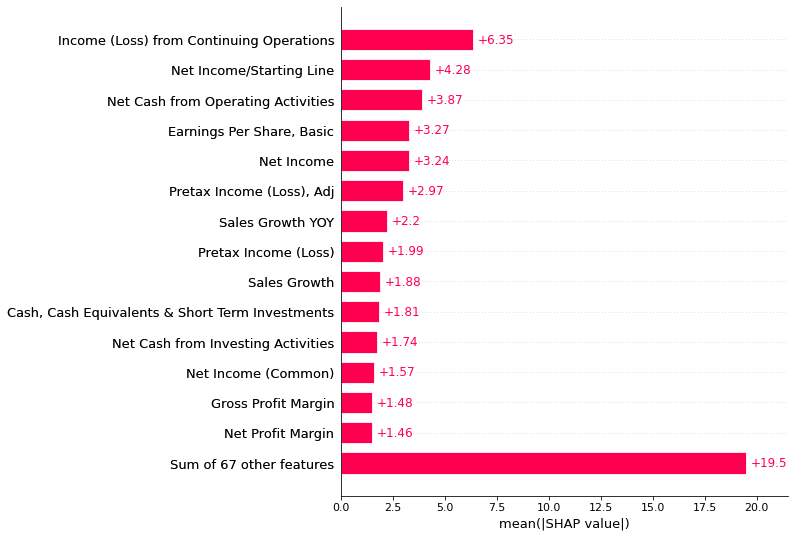

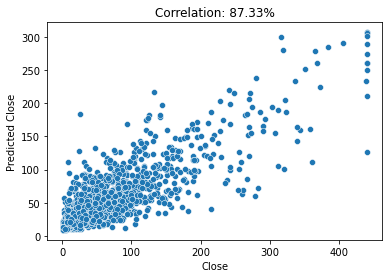

In [18]:
# Common
# List of all unique stock-tickers in the dataset.
tickers = df.reset_index()[TICKER].unique()
tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=20)

model_df = df[df.index.get_level_values(1) == df.index.get_level_values(1).max()]
model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.01)

# Do this for the Explainer Dashboard (It is fussy about column names)
model_df.columns = model_df.columns.str.replace('.', '')

train = model_df.loc[tickers_train]
test = model_df.loc[tickers_test]

# DataFrames with signals for training- and test-sets.
X = model_df.drop(columns=['Close'])
X_train = train.drop(columns=['Close'])
X_test = test.drop(columns=['Close'])

# DataFrames with stock-returns for training- and test-sets.
y = model_df['Close']
y_train = train['Close']
y_test = test['Close']

# Model Building
model = XGBRegressor(learning_rate=0.01,
                     max_depth=3,
                     subsample=.5,
                     colsample_bylevel=0.7,
                     colsample_bytree=0.7,
                     n_estimators=200)

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# retrieve performance metrics
results = model.evals_result()
results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
                           pd.Series(results['validation_1']['rmse'], name='Test')]).T

sns.lineplot(data=results_df, dashes=False)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost RMSE')
plt.show()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# y_pred = model.predict(X)

data = {
    'Train/Test':['Train', 'Test'],
    'R2 Score':[],
    'RMSE':[]
}

data['R2 Score'].append(r2_score(y_train, y_train_pred))
data['R2 Score'].append(r2_score(y_test, y_test_pred))

data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print(pd.DataFrame(data).set_index('Train/Test'))

# Shap Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print('\n\nFeature Importance')
shap.plots.bar(shap_values, max_display=15)

# Correlation Plot
plot_correlation(model, X, y)

final_df = df.copy()
# Do this for the Explainer Dashboard (It is fussy about column names)
final_df.columns = final_df.columns.str.replace('.', '')
model.fit(X, y, verbose=False)
final_df['Predicted Close'] = model.predict(final_df.drop(['Close'], axis=1))
final_df['Model'] = 'Common'

final_df = final_df.sort_index(level=['Ticker', 'Date'], ascending=[1, 1])

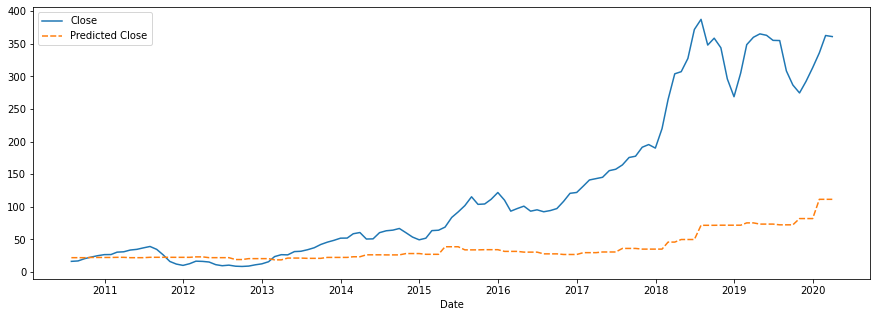

In [19]:
# Create Single Stock Analyzer
ticker = 'NFLX'

data = final_df.loc[ticker][['Close', 'Predicted Close']]
plt.figure(figsize=(15,5))
sns.lineplot(data=data);

In [20]:
len(df.index.get_level_values(0).unique())

1928

In [104]:
import datetime
DATA_DIR = pathlib.Path('./data')
mtime = (DATA_DIR/'analyst_growth_target.csv').stat().st_mtime
mtime = pd.to_datetime(datetime.datetime.fromtimestamp(mtime))
days_since_update = (pd.to_datetime('today') - mtime).days

In [105]:
days_since_update

0

In [108]:
for ticker in company_df.index:
    try:
        df = si.get_analysts_info(ticker)['Growth Estimates'].set_index(
            'Growth Estimates')[[ticker]].T
        dfs.append(df)
    except:
        pass

growth_df = pd.concat(dfs)
growth_df = growth_df.applymap(lambda x: float(
    x.strip('%').replace(",", ""))/100 if pd.notnull(x) else x)
growth_df.to_csv('analyst_growth_estimates.csv')

In [109]:
pd.read_csv(DATA_DIR/'analyst_growth_estimates.csv')

,Unnamed: 0,Current Qtr.,Next Qtr.,Current Year,Next Year,Next 5 Years (per annum),Past 5 Years (per annum)
0,A,15.50%,16.70%,18.60%,11.80%,10.80%,8.07%
1,BIO,57.10%,64.00%,8.70%,7.20%,17.80%,12.03%
2,CDNA,NaN,NaN,-13.00%,235.00%,20.00%,NaN
3,CRL,19.00%,34.80%,12.50%,12.30%,13.87%,15.40%
4,DGX,295.70%,108.50%,-0.90%,-27.70%,9.22%,9.20%
...,...,...,...,...,...,...,...
1570,MO,-4.60%,8.30%,5.00%,6.60%,4.42%,11.39%
1571,PM,15.70%,18.60%,16.10%,9.30%,11.21%,3.91%
1572,TPB,25.50%,11.30%,7.50%,13.90%,22.80%,29.16%
1573,VGR,733.30%,29.40%,-3.30%,4.50%,6.40%,5.47%


In [68]:
growth_df = pd.concat(dfs)#.to_csv('analyst_growth_target.csv')

In [69]:
sales_growth_df = df[df.index.get_level_values(
        1) == df.index.get_level_values(1).max()].reset_index(level=1, drop=True)['Sales Growth']

In [70]:
growth_df = growth_df.applymap(lambda x: float(x.strip('%').replace(",", ""))/100 if pd.notnull(x)  else x)

In [71]:
growth_df = growth_df.reindex(sales_growth_df.index)

growth_df = growth_df.join(company_df).merge(industry_df,  left_on='IndustryId', right_index=True)#.columns

growth_df = growth_df[['Next 5 Years (per annum)','Industry']]

growth_df['Growth'] = growth_df.groupby('Industry').transform(lambda x: x.fillna(x.mean()))

(growth_df['Growth']+1)**5

# COLUMNS TO UPDATE IN FEATURE (IF NEGATIVE LEAVE THE SAME FOR NOW)
['Cash, Cash Equivalents & Short Term Investments', 
  'Net Cash from Operating Activities', 
  'Net Income',
  'Income (Loss) from Continuing Operations',
  'Earnings Per Share, Basic',
   'Net Cash from Investing Activities',
  'Earnings Per Share, Diluted',
  'Pretax Income (Loss), Adj.',
  'Gross Profit',
  'Net Income (Common)'
 ]

In [93]:
growth_df

,Next 5 Years (per annum),Industry,Growth
Ticker,,,
A,0.11,Medical Diagnostics & Research,0.11
ARA,0.18,Medical Diagnostics & Research,0.18
BIO,0.18,Medical Diagnostics & Research,0.18
CDNA,0.20,Medical Diagnostics & Research,0.20
CRL,0.14,Medical Diagnostics & Research,0.14
...,...,...,...
MO,0.04,Tobacco Products,0.04
PM,0.11,Tobacco Products,0.11
TPB,0.23,Tobacco Products,0.23


In [88]:
(growth_df['Growth']+1)**5

Ticker
A       1.67
ARA     2.30
BIO     2.27
CDNA    2.49
CRL     1.91
        ... 
MO      1.24
PM      1.70
TPB     2.79
VGR     1.36
Y      12.42
Name: Growth, Length: 1720, dtype: float64

In [97]:
df[df.index.get_level_values(1) == df.index.get_level_values(1).max()].reset_index(level=1, drop=True)

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Total Current Assets,"Property, Plant & Equipment, Net",Other Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Total Equity,Total Liabilities & Equity,Net Income/Starting Line,Non-Cash Items,Change in Working Capital,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Cash from Investing Activities,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,Return on Assets,Return on Equity,Share Buyback / FCF,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,EBITDA,Total Debt,Free Cash Flow,Operating Margin,Free Cash Flow to Net Income,Liabilities to Equity Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Pietroski F-Score,Close,Sector,Industry
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,"312,000,000.00","315,750,000.00",16.58,-7.65,8.93,-6.06,-4.78,2.87,-0.05,-0.15,2.82,2.82,-0.40,2.42,2.42,2.42,3.88,3.06,9.82,2.67,17.22,20.27,30.09,1.04,5.99,5.66,8.74,14.74,16.77,0.23,15.35,30.09,2.42,0.41,-1.29,2.37,-0.48,-4.23,2.08,-2.04,-0.75,-2.63,1.43,0.55,0.57,1.64,0.35,0.54,19.28,9.72,0.15,1.16,0.08,0.16,1.08,0.06,0.01,0.06,-0.33,0.02,-0.61,-0.36,-1.33,-1.53,0.05,-0.01,0.06,3.70,7.80,2.34,0.17,0.97,0.96,2.45,2.42,16.78,15.54,2.37,5.00,77.55,1,1
ARA,"32,274,570.00","32,274,570.00",25.49,-18.91,6.58,-4.18,-2.82,2.40,-1.35,-1.35,1.05,0.26,0.55,0.81,-0.43,-0.68,1.07,3.17,6.82,4.68,22.17,26.86,33.67,3.85,5.92,17.01,21.22,27.13,3.13,-5.52,6.54,33.67,0.81,0.19,-1.16,1.20,-0.72,-0.63,0.75,0.00,-1.22,-0.64,0.00,0.76,0.53,1.15,0.00,0.26,1.78,8.92,-0.02,0.72,-0.01,-0.07,-0.00,0.10,-0.03,0.10,-0.52,-0.98,-1.01,-0.74,-1.06,-1.23,0.02,-0.03,0.13,3.76,18.21,1.33,0.09,-1.97,4.15,-0.68,-0.68,25.49,-2.45,1.33,5.00,8.37,1,1
BIO,"29,843,000.00","30,184,000.00",76.59,-34.94,41.64,-34.04,-27.32,7.61,0.01,-0.78,7.62,74.91,-16.64,58.27,58.27,58.27,36.93,13.01,72.23,16.54,22.90,193.11,265.33,10.71,30.00,0.45,44.67,74.67,13.58,181.25,190.67,265.33,0.00,15.17,0.00,15.17,-2.97,-6.92,0.09,-0.49,-0.75,7.57,0.04,0.29,0.00,2.41,-0.00,0.54,9.81,9.36,0.76,1.66,0.22,0.31,0.04,0.43,0.12,0.43,3.81,-3.14,-1.67,1.21,1.03,1.73,0.01,0.11,0.01,0.00,0.45,0.00,0.10,0.00,0.39,58.93,58.27,77.46,192.84,0.00,6.00,369.28,1,1
CDNA,"42,151,617.00","42,151,617.00",3.01,-1.08,1.94,-2.52,-1.79,-0.58,0.01,0.02,-0.58,-0.57,0.05,-0.52,-0.52,-0.52,0.91,0.57,1.71,0.11,1.79,1.89,3.60,0.83,0.83,0.32,0.42,1.25,10.39,-7.92,2.35,3.60,-0.52,0.57,-0.25,-0.07,-0.08,-0.54,-0.00,0.10,-0.00,-0.62,0.70,0.84,0.61,2.07,0.00,0.64,24.91,8.10,-0.17,1.79,-0.14,-0.22,0.70,0.16,0.05,0.16,-0.53,1.63,0.27,-0.46,-14.45,-3.23,0.66,0.06,0.52,-0.45,0.00,-0.82,-0.19,1.58,0.53,-0.52,-0.52,3.01,2.35,-0.82,4.00,22.59,1,1
CRL,"48,730,000.00","49,693,000.00",52.75,-33.46,19.28,-12.22,-10.42,7.07,-0.95,-1.19,6.12,6.12,-1.01,5.11,5.07,5.07,4.79,10.34,20.55,21.01,52.87,73.88,94.44,8.24,14.29,37.22,46.61,60.90,30.83,5.64,33.54,94.44,5.11,0.45,0.12,9.68,-2.83,-13.71,-62.88,-0.36,4.67,0.86,0.05,0.56,0.71,1.44,-0.0

In [98]:
df[df.index.get_level_values(1) == df.index.get_level_values(1).max()].reset_index(level=1, drop=True).columns

Index(['Shares (Basic)', 'Shares (Diluted)', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations', 'Net Income',
       'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Retained Earnings',
       'Total Equity', 'Total Liabilities & Equity',
       'Net Income/Starting Line', 'Non-Cas

In [ ]:
 ['Cash, Cash Equivalents & Short Term Investments', 
  'Net Cash from Operating Activities', 
  'Net Income',
  'Income (Loss) from Continuing Operations',
  'Earnings Per Share, Basic',
   'Net Cash from Investing Activities',
  'Earnings Per Share, Diluted',
  'Pretax Income (Loss), Adj.',
  'Gross Profit',
  'Net Income (Common)'
 ]

In [107]:
company_df.index

Index(['A', 'AA', 'AAC', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP',
       ...
       'ZIOP', 'ZM', 'ZMH', 'ZNGA', 'ZS', 'ZTS', 'ZUMZ', 'ZUO', 'ZYNE',
       'ZYXI'],
      dtype='object', name='Ticker', length=2690)

In [ ]:
xpl = SmartExplainer()

In [ ]:
X.index = X.index.droplevel(1)
xpl.compile(
    x=X,
    model=common_model,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
)

In [ ]:
xpl.plot.features_importance()

In [ ]:
xpl.plot.local_plot(index='MSFT')

In [ ]:
X.loc[['NFLX', 'ELY']]

In [ ]:
##################### TESTING 

In [ ]:
from predict import *
DATA_DIR = pathlib.Path('./data')

common_df = load_dataset(dataset='common', simfin_api_key=SIMFIN_API_KEY)

common_model = train(common_df,
                     winsor_quantile=0.01,
                     model_name='common_model',
                     feature_name='common',
                     model_input=dict(learning_rate=0.01,
                                      max_depth=2,
                                      subsample=.5,
                                      colsample_bylevel=0.7,
                                      colsample_bytree=0.7,
                                      n_estimators=210))

common_predictions = predict(common_model, common_df, 'common_predictions')

In [ ]:
dfs = []
for sector in ['common', 'banks', 'insurance']:
    df = pd.read_csv(
        DATA_DIR/f'{sector}_predictions.csv', index_col=['Ticker', 'Date'], parse_dates=['Date'])
    dfs.append(df)
prediction_df = pd.concat(dfs)

In [ ]:
prediction_df.loc['GME']

In [ ]:
# Create Single Stock Analyzer
ticker = 'GME'

data = common_predictions.loc[ticker][['Close', 'Predicted Close']]
plt.figure(figsize=(15,5))
sns.lineplot(data=df.loc[ticker][['Close', 'Predicted Close']]);

In [ ]:


# common_df = load_dataset(dataset='common', simfin_api_key=SIMFIN_API_KEY)

In [45]:
float('-4000.00')

-4000.0

In [ ]:
X = df.drop(columns=['Close', 'Model', 'Predicted Close'])

# Filter Dataset to current Stock Prices Only
X = X[X.index.get_level_values(1) == X.index.get_level_values(1).max()]

features = pd.Series(common_model.feature_importances_, index=X.columns).sort_values(
    ascending=False).index[:15]

tickers = X.index.get_level_values(0)

similarity_matrix = cosine_similarity(X[features])

matrix_df = pd.DataFrame(similarity_matrix, index=tickers, columns=tickers)

# matrix_df.to_csv(DATA_DIR/f'{filename}.csv')

In [ ]:
matrix_df.head()

In [ ]:
len(common_model.feature_importances_)

In [ ]:
# Similiraty

number_of_features = 15
ticker = 'ELY'

important_featurs = pd.Series(common_model.feature_importances_, index = X.columns).sort_values(ascending=False).index[:number_of_features]
tickers = X.index.get_level_values(0)
pd.DataFrame(cosine_similarity(X[important_featurs]), index=tickers, columns=tickers).loc[ticker].sort_values(ascending=False)

In [ ]:
# # Banks

# # List of all unique stock-tickers in the dataset.
# tickers = banks_df.reset_index()[TICKER].unique()
# tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

# model_df = banks_df[banks_df.index.get_level_values(1) == banks_df.index.get_level_values(1).max()]
# model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.05)

# train = model_df.loc[tickers_train]
# test = model_df.loc[tickers_test]

# # DataFrames with signals for training- and test-sets.
# X = model_df.drop(columns=['Close'])
# X_train = train.drop(columns=['Close'])
# X_test = test.drop(columns=['Close'])

# # DataFrames with stock-returns for training- and test-sets.
# y = model_df['Close']
# y_train = train['Close']
# y_test = test['Close']


# # Model Building

# bank_model = XGBRegressor(learning_rate=0.01, 
#                      max_depth=2,
#                      subsample=.8,
#                      colsample_bylevel=0.7,
#                      colsample_bytree=0.7,
# #                      reg_lambda=0.1,
#                      n_estimators=200) 

# # https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# eval_set = [(X_train, y_train), (X_test, y_test)]
# bank_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# # retrieve performance metrics
# results = bank_model.evals_result()
# results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
#                            pd.Series(results['validation_1']['rmse'], name='Test')]).T

# sns.lineplot(data=results_df, dashes=False)
# plt.ylabel('RMSE')
# plt.xlabel('Epochs')
# plt.title('XGBoost RMSE')
# plt.show()

# y_train_pred = bank_model.predict(X_train)
# y_test_pred = bank_model.predict(X_test)
# y_pred = bank_model.predict(X)

# data = {
#     'Train/Test':['Train', 'Test'],
#     'R2 Score':[],
#     'RMSE':[]
# }

# data['R2 Score'].append(r2_score(y_train, y_train_pred))
# data['R2 Score'].append(r2_score(y_test, y_test_pred))

# data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
# data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# print(pd.DataFrame(data).set_index('Train/Test'))

# # Shap Explainer
# explainer = shap.TreeExplainer(bank_model)
# shap_values = explainer(X)
# print('\n\nFeature Importance')
# shap.plots.bar(shap_values, max_display=10)

# # Correlation Plot
# plot_correlation(bank_model, X, y)

# df = banks_df.copy()
# bank_model.fit(X, y, verbose=False)
# df['Predicted Close'] = bank_model.predict(df.drop(['Close'], axis=1))
# df['Model'] = 'Common'

In [ ]:
# # Insurance

# # List of all unique stock-tickers in the dataset.
# tickers = insurance_df.reset_index()[TICKER].unique()
# tickers_train, tickers_test = train_test_split(tickers, train_size=0.60, random_state=69420)

# model_df = insurance_df[insurance_df.index.get_level_values(1) == insurance_df.index.get_level_values(1).max()]
# model_df = sf.winsorize(model_df, clip=True, columns=['Close'], quantile=0.08)

# train = model_df.loc[tickers_train]
# test = model_df.loc[tickers_test]

# # DataFrames with signals for training- and test-sets.
# X = model_df.drop(columns=['Close'])
# X_train = train.drop(columns=['Close'])
# X_test = test.drop(columns=['Close'])

# # DataFrames with stock-returns for training- and test-sets.
# y = model_df['Close']
# y_train = train['Close']
# y_test = test['Close']

# # Model Building

# insurance_model = XGBRegressor(learning_rate=0.01, 
#                      max_depth=2,
#                      subsample=1,
#                      colsample_bylevel=0.7,
#                      colsample_bytree=0.7,
#                      n_estimators=150)

# # https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# eval_set = [(X_train, y_train), (X_test, y_test)]
# insurance_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# # retrieve performance metrics
# results = insurance_model.evals_result()
# results_df = pd.DataFrame([pd.Series(results['validation_0']['rmse'], name='Train'),
#                            pd.Series(results['validation_1']['rmse'], name='Test')]).T

# sns.lineplot(data=results_df, dashes=False)
# plt.ylabel('RMSE')
# plt.xlabel('Epochs')
# plt.title('XGBoost RMSE')
# plt.show()

# y_train_pred = insurance_model.predict(X_train)
# y_test_pred = insurance_model.predict(X_test)
# y_pred = insurance_model.predict(X)

# data = {
#     'Train/Test':['Train', 'Test'],
#     'R2 Score':[],
#     'RMSE':[]
# }

# data['R2 Score'].append(r2_score(y_train, y_train_pred))
# data['R2 Score'].append(r2_score(y_test, y_test_pred))

# data['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
# data['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# print(pd.DataFrame(data).set_index('Train/Test'))

# # Shap Explainer
# explainer = shap.TreeExplainer(insurance_model)
# shap_values = explainer(X)
# print('\n\nFeature Importance')
# shap.plots.bar(shap_values, max_display=10)

# # Correlation Plot
# plot_correlation(insurance_model, X, y)

# df = insurance_df.copy()
# insurance_model.fit(X, y, verbose=False)
# df['Predicted Close'] = insurance_model.predict(df.drop(['Close'], axis=1))
# df['Model'] = 'Common'

In [ ]:
# Create Single Stock Analyzer
ticker = 'AAMC'

data = df.loc[ticker][['Close', 'Predicted Close']]
plt.figure(figsize=(15,5))
sns.lineplot(data=df.loc[ticker][['Close', 'Predicted Close']]);

In [ ]:
shap_values

In [ ]:
explainer = shap.TreeExplainer(common_model)
shap_values = explainer(X.loc['ELY'])
shap.waterfall_plot(shap_values.values)

In [ ]:
final_df.loc[ticker,max_date].to_frame()

In [ ]:
final_df.loc[(slice(ticker,ticker), slice(max_date, max_date)),:].drop(['Close', 'Predicted Close', 'Model'], axis=1)  

In [ ]:
explainer = shap.TreeExplainer(common_model)
max_date = final_df.index.get_level_values(1).max()
shap_values = explainer(final_df.loc[(slice(ticker,ticker), slice(max_date, max_date)),:].drop(['Close', 'Predicted Close', 'Model'], axis=1)  )[0]
shap.waterfall_plot(shap_values)

In [ ]:
final_df.

In [ ]:
df.loc['AAME'][['Close', 'Predicted Close']]

In [ ]:
df.loc[(slice('UVE','UVE'), slice(max_date, max_date)),:].drop(['Predicted Close', 'Model'], axis=1)

In [ ]:
explainer = shap.TreeExplainer(common_model)

In [ ]:
X = df.drop(columns=['Close', 'Model', 'Predicted Close'])

# Filter Dataset to current Stock Prices Only
X = X[X.index.get_level_values(1) == X.index.get_level_values(1).max()]

In [ ]:
test = explainer(X.loc['AMZN'])

In [ ]:
shap.waterfall_plot(test[0], max_display=15)

In [ ]:
explainer(X.loc['AAPL'])

In [ ]:
X.index.get_level_values(0)

In [ ]:
shap.TreeExplainer?

In [ ]:
pred_df['1 Year Change'] = pred_df.groupby(
    'Ticker')['Close'].pct_change(12).shift(-12)

pred_df['Perc of Close'] = pred_df['Pred Close'].div(pred_df['Close'])
pred_df = pred_df.dropna()


In [ ]:
pred_df

In [ ]:
(pred_df['Pred Close'] / pred_df['Close']) - 1

In [ ]:
from  matplotlib.ticker import PercentFormatter

g = sns.scatterplot(data=sf.winsorize(pred_df[['Perc of Close', '1 Year Change', 'Ticker']],
                                  quantile=.05, clip=False, exclude_columns=['Ticker']), x='Perc of Close', y='1 Year Change')


g.yaxis.set_major_formatter(PercentFormatter(1))
g.xaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
pred_df[pred_df.Date == pred_df.Date.max()].sort_values(by='1 Year Change', ascending=False).head(50)

In [ ]:
X.index.get_level_values(0).to_list()

In [ ]:
test = dict(learning_rate=0.01,
                             max_depth=2,
                             subsample=.5,
                             colsample_bylevel=0.7,
                             colsample_bytree=0.7,
                             n_estimators=210)

In [ ]:
XGBRegressor(kwargs=test)

In [ ]:
#EXPLAINER DASHBOARD

DATA_DIR = pathlib.Path('./data')
MODELS_DIR = pathlib.Path('./models')

model = pickle.load(open(MODELS_DIR/'common_model.pkl', 'rb'))

y = pd.read_csv(DATA_DIR/'common_target.csv', index_col=['Ticker']).drop(columns=['Date'])
X = pd.read_csv(DATA_DIR/f'common_features.csv', index_col=['Ticker']).drop(columns=['Date'])

X.columns = X.columns.str.replace('.', '')

feature_names = model.get_booster().feature_names
feature_names = [x.replace('.', '') for x in feature_names]
model.get_booster().feature_names = feature_names

from explainerdashboard import RegressionExplainer, ExplainerDashboard
explainer = RegressionExplainer(model, X, y)

ExplainerDashboard(explainer, mode='inline').run(port=8080)